In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

/home/marina/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


# Load data

In [59]:
# # description file -- not pandas-friendly
# df_dict = pd.read_excel('../data/pulse2020_data.dictionary_CSV_01.xlsx')
WEEK_IDX_RANGE = range(1, 14)

data = {
    n: pd.read_csv(f'../data/pulse2020_puf_{n:02d}.csv')
    for n in WEEK_IDX_RANGE
}
df = pd.read_csv('../data/pulse2020_puf_01.csv')

In [60]:
# check each participant has one entry in a given survey
for n in WEEK_IDX_RANGE:
    assert len(data[n]['SCRAM'].unique()) == len(data[n])

In [64]:
base_week_idx = 6

init_scram_set = set(data[base_week_idx]['SCRAM'])
people_funnel = [len(init_scram_set)]

for n in WEEK_IDX_RANGE[base_week_idx:]:
    intersect_scram_set = init_scram_set.intersection(set(data[n]['SCRAM']))
    people_funnel.append(len(intersect_scram_set))

people_funnel

[83302, 14316, 3417, 0, 0, 0, 0, 0]

In [195]:
out_nk[:20]

array([[ 1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [ 1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [ 1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [ 1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [ 1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [ 1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [ 1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [ 1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [ 1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [ 1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [ 1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [ 1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [ 1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [ 1., -1., -1., -1., -1., -1., 

In [191]:
counts_kk[6, :]

array([    0.,     0.,     0.,     0.,     0.,     0., 59065., 11984.,
        4755.,     0.,     0.,     0.,     0.])

In [93]:
df1 = data[1][['SCRAM', 'WEEK']].copy()
df2 = data[2][['SCRAM', 'WEEK']].copy()

In [228]:
new_data = []
for i, tmp_df in data.items():
    tmp_df = tmp_df[['SCRAM']].copy()
    tmp_df.index = tmp_df.SCRAM
    tmp_df[str(i)] = i
    del tmp_df['SCRAM']
    new_data.append(tmp_df)

from functools import reduce
kwargs = dict(how='outer', left_index=True, right_index=True, )
out = reduce(lambda x, y: pd.merge(x, y, **kwargs), new_data)

# 
out_nk = out.values
is_valid_nk = np.isfinite(out_nk)
out_nk[~is_valid_nk] = 100000
out_nk = np.minimum.accumulate(out_nk, axis=1)
out_nk[~is_valid_nk] = -1


n_k = out_nk.shape[1]
# where k means from which week person is visiting
# and w is the week we are looking at to
counts_kw = np.zeros((n_k, n_k))
for k_idx in range(n_k):
    counts_kw[k_idx] = (out_nk == k_idx + 1).sum(axis=0)

df = pd.DataFrame(data=counts_kw.T, index=np.arange(n_k), columns=np.arange(n_k))
df.index.name = 'week number'

In [229]:
counts_kw.sum(axis=0)

array([ 74413.,  41996., 132961., 101215., 105066.,  83302.,  73472.,
       108062.,  98663.,  90767.,  91605.,  86792., 109051.])

In [230]:
out_nk.shape

(959069, 13)

In [231]:
np.diag(counts_kw).sum()

959069.0

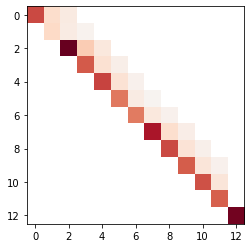

In [244]:
from matplotlib import cm
counts_kw_copy = counts_kw.copy()
counts_kw_copy[counts_kw_copy == 0] = np.nan
plt.imshow(counts_kw_copy, vmin=-counts_kw.max(), vmax=counts_kw.max(), cmap=cm.RdBu_r)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc8ad67d390>,
      dtype=object)

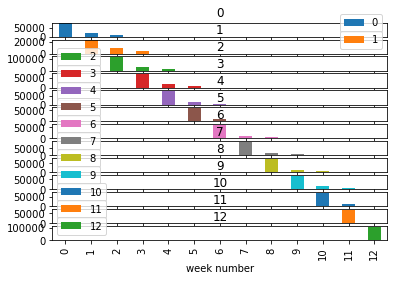

In [209]:
df.plot.bar(subplots=True)

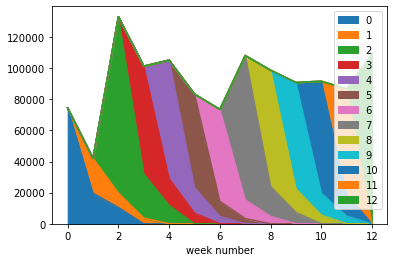

In [207]:
df.plot.area()

In [257]:
counts_kw[:5, :5]

array([[ 74413.,  19585.,  10466.,      0.,      0.],
       [     0.,  22411.,   9324.,   3713.,      0.],
       [     0.,      0., 113171.,  28318.,  11816.],
       [     0.,      0.,      0.,  69184.,  17114.],
       [     0.,      0.,      0.,      0.,  76136.]])

array([[ 74413.,  19585.,  10466.,      0.,      0.],
       [ 74413.,  41996.,  19790.,   3713.,      0.],
       [ 74413.,  41996., 132961.,  32031.,  11816.],
       [ 74413.,  41996., 132961., 101215.,  28930.],
       [ 74413.,  41996., 132961., 101215., 105066.]])

In [274]:

plt.style.use('ggplot')

In [280]:

import matplotlib as mpl
import numpy as np

# Set the default color cycle

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["r", "k", "c"]) 

In [314]:
import seaborn as sns
sns.set_style("whitegrid")

In [315]:
clrs = sns.color_palette('gist_ncar', n_colors=13)

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=clrs) 

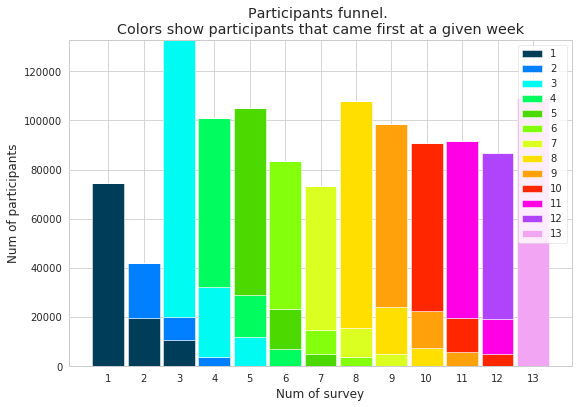

In [319]:
fig, axis = plt.subplots(1, 1, figsize=(9,6))

shifted_cum_counts_kw = np.concatenate((np.zeros(n_k)[None, :], counts_kw.cumsum(axis=0)), axis=0)
x_k = np.arange(1, n_k + 1)

for k_idx in range(n_k):
    p1 = axis.bar(x_k, counts_kw[k_idx], 0.9, 
                 bottom=shifted_cum_counts_kw[k_idx], label=k_idx + 1)
axis.xaxis.set_ticks(np.arange(1, 14, 1))
axis.set_title('Participants funnel. \nColors show participants that came first at a given week')
axis.set_xlabel('Num of survey')
axis.set_ylabel('Num of participants')
axis.legend()
fig.savefig('../figures/participants_funnel.png')

In [96]:
df1.index = df1.SCRAM
df2.index = df2.SCRAM

In [97]:
pd.merge(df1, df2, how='outer', left_index=True, right_index=True)

,SCRAM_x,WEEK_x,SCRAM_y,WEEK_y
SCRAM,,,,
V010000001S10011099370111,V010000001S10011099370111,1.0,NaN,NaN
V010000001S10011900470112,V010000001S10011900470112,1.0,V010000001S10011900470112,2.0
V010000001S18010744940111,V010000001S18010744940111,1.0,NaN,NaN
V010000001S37010301340112,V010000001S37010301340112,1.0,NaN,NaN
V010000001S37010480340111,V010000001S37010480340111,1.0,NaN,NaN
...,...,...,...,...
V029950005S53551995090021,NaN,NaN,V029950005S53551995090021,2.0
V029950005S78550018850011,NaN,NaN,V029950005S78550018850011,2.0
V029950006S12560322330011,NaN,NaN,V029950006S12560322330011,2.0


In [81]:
pd.merge(data[1][['SCRAM']], data[2][['SCRAM']], how='outer', on='SCRAM')

,SCRAM
0,V010000001S10011099370111
1,V010000001S10011900470112
2,V010000001S18010744940111
3,V010000001S37010301340112
4,V010000001S37010480340111
...,...
96819,V029950005S53551995090021
96820,V029950005S78550018850011
96821,V029950006S12560322330011
96822,V029950006S91560331420011


# EDA

In [17]:
race_from_num = {
    1: 'white',
    2: 'black',
    3: 'asian',
    4: 'other',
}

df['RRACE'].apply(lambda x: race_from_num[x]).value_counts()

white    61376
black     6258
other     3472
asian     3307
Name: RRACE, dtype: int64

In [ ]:
var = 'WRKLOSS'
